# Investigating molecular blood-brain-barrier permeability

The blood-brain-barrier (BBB) is a selective semipermeable membrane that separates circulating blood from the brain and extracellular fluid in the central nervous system. It is composed of capillary endothelial cells, pericytes, and astrocytic end-feet, which together restrict the passage of solutes from the bloodstream into the brain. The BBB is a major obstacle in the treatment of neurological disorders, as it prevents many drugs from reaching the brain Understanding the permeability of molecules to the BBB is therefore of great interest to facilitate the development of new neurotherapeutics. 

Here, we use techniques studied during the Fall 2023 semester in PHYSCI 2 Lab at Harvard College to study the relationships between several molecular properties and BBB permeability. First, we load relevant libraries.

In [23]:
# standard imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# molecular manipulation
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

# clustering
from sklearn.cluster import AgglomerativeClustering

# path manipulation
from pathlib import Path

# import project configuration
import project_config

Next, we read the data into a `pandas` dataframe.

In [2]:
# read in data
data = pd.read_csv(project_config.PROJECT_DIR / 'B3DB_regression.tsv', sep='\t')
data.head()

,NO.,compound_name,IUPAC_name,SMILES,CID,logBB,Inchi,reference,group,comments
0,1,moxalactam,7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...,CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)C(C4=CC=C...,3889.0|,-2.52,InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...,R25|,A,NaN
1,2,schembl614298,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...",CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC6[C@...,18595497.0|,-2.15,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-4-12(25)2...,R25|,A,NaN
2,3,morphine-6-glucuronide,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-9-hydro...",CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@...,9847115.0|,-2.09,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-5-13(31-2...,R25|,A,NaN
3,4,2-[4-(5-bromo-3-methylpyridin-2-yl)butylamino]...,2-[4-(5-bromo-3-methylpyridin-2-yl)butylamino]...,CC1=NC=C(C=C1)CC2CNC(NC2=O)NCCCCC3=NC=C(C=C3C)Br,74041479.0|,-1.88,InChI=1S/C21H28BrN5O/c1-14-9-18(22)13-25-19(14...,R35|,A,NaN
4,5,NaN,NaN,c1(c2c3n(c4c(C(N(C)C3)=O)c(Cl)ccc4)cn2)noc(C(O...,nan|,-1.82,"InChI=1S/C16H14ClN5O4/c1-16(24,25)15-19-13(20-...",R35|,A,NaN


We use the RDKit library to calculate various molecular features from the SMILES structures. Simplied molecular-input line-entry system, or SMILES, is a specification for describing the structure of chemical species using short ASCII strings. RDKit is an open-source cheminformatics toolkit that supports many common tasks in cheminformatics, including molecular property calculation.

Compound Name:  moxalactam


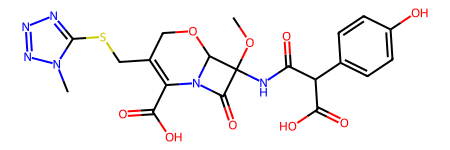

In [3]:
# get molecule from SMILES
data['mol'] = data['SMILES'].apply(Chem.MolFromSmiles)

# visualize first molecule
print("Compound Name: ", data['compound_name'].iloc[0])
data['mol'].iloc[0]

Extract molecular features from SMILES strings.

In [4]:
# to calculate all 210 descriptors
# descriptors = data['mol'].apply(lambda x: pd.Series(Chem.Descriptors.CalcMolDescriptors(x)))

# get average molecular weight (MolWt)
data['mol_wt'] = data['mol'].apply(lambda x: Descriptors.MolWt(x))

# get exact molecular weight (ExactMolWt)
data['exact_mol_wt'] = data['mol'].apply(lambda x: Descriptors.ExactMolWt(x))

# get average molecular weight ignoring hydrogens (HeavyAtomMolWt)
data['heavy_atom_mol_wt'] = data['mol'].apply(lambda x: Descriptors.HeavyAtomMolWt(x))

# get average number of hydrogen bond acceptors (NumHAcceptors)
data['num_h_acceptors'] = data['mol'].apply(lambda x: Descriptors.NumHAcceptors(x))

# get average number of hydrogen bond donors (NumHDonors)
data['num_h_donors'] = data['mol'].apply(lambda x: Descriptors.NumHDonors(x))

# get number of heavy atoms (HeavyAtomCount)
data['heavy_atom_count'] = data['mol'].apply(lambda x: Descriptors.HeavyAtomCount(x))

# get number of aromatic atoms (NumAromaticRings)
data['num_aromatic_rings'] = data['mol'].apply(lambda x: Descriptors.NumAromaticRings(x))

# get number of rings (NumRings)
data['num_rings'] = data['mol'].apply(lambda x: Descriptors.RingCount(x))

# get number of rotatable bonds (NumRotatableBonds)
data['num_rotatable_bonds'] = data['mol'].apply(lambda x: Descriptors.NumRotatableBonds(x))

# show first 5 rows of data
data.head()

,NO.,compound_name,IUPAC_name,SMILES,CID,logBB,Inchi,reference,group,comments,mol,mol_wt,exact_mol_wt,heavy_atom_mol_wt,num_h_acceptors,num_h_donors,heavy_atom_count,num_aromatic_rings,num_rings,num_rotatable_bonds
0,1,moxalactam,7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...,CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)C(C4=CC=C...,3889.0|,-2.52,InChI=1S/C20H20N6O9S/c1-25-19(22-23-24-25)36-8...,R25|,A,NaN,<rdkit.Chem.rdchem.Mol object at 0x16a940e40>,520.480,520.101247,500.320,12,4,36,2,4,9
1,2,schembl614298,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...",CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC6[C@...,18595497.0|,-2.15,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-4-12(25)2...,R25|,A,NaN,<rdkit.Chem.rdchem.Mol object at 0x16a940eb0>,461.467,461.168581,434.251,9,5,33,1,6,3
2,3,morphine-6-glucuronide,"(2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-9-hydro...",CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@...,9847115.0|,-2.09,InChI=1S/C23H27NO9/c1-24-7-6-23-10-3-5-13(31-2...,R25|,A,NaN,<rdkit.Chem.rdchem.Mol object at 0x16a940f20>,461.467,461.168581,434.251,9,5,33,1,6,3
3,4,2-[4-(5-bromo-3-methylpyridin-2-yl)butylamino]...,2-[4-(5-bromo-3-methylpyridin-2-yl)butylamino]...,CC1=NC=C(C=C1)CC2CNC(NC2=O)NCCCCC3=NC=C(C=C3C)Br,74041479.0|,-1.88,InChI=1S/C21H28BrN5O/c1-14-9-18(22)13-25-19(14...,R35|,A,NaN,<rdkit.Chem.rdchem.Mol object at 0x16a941000>,446.393,445.147723,418.169,5,3,28,2,3,8
4,5,NaN,NaN,c1(c2c3n(c4c(C(N(C)C3)=O)c(Cl)ccc4)cn2)noc(C(O...,nan|,-1.82,"InChI=1S/C16H14ClN5O4/c1-16(24,25)15-19-13(20-...",R35|,A,NaN,<rdkit.Chem.rdchem.Mol object at 0x16a940f90>,375.772,375.073432,361.660,8,2,26,3,4,2


Visualize relationship between molecular weight and logBB. Note that the logBB is the logarithm of the ratio of the concentration of the compound in the brain to the concentration in the plasma. 
$$\log{BB} = \log{\frac{C_{brain}}{C_{blood}}}$$

If the logBB is positive, then a compound is BBB permeable and vice versa.

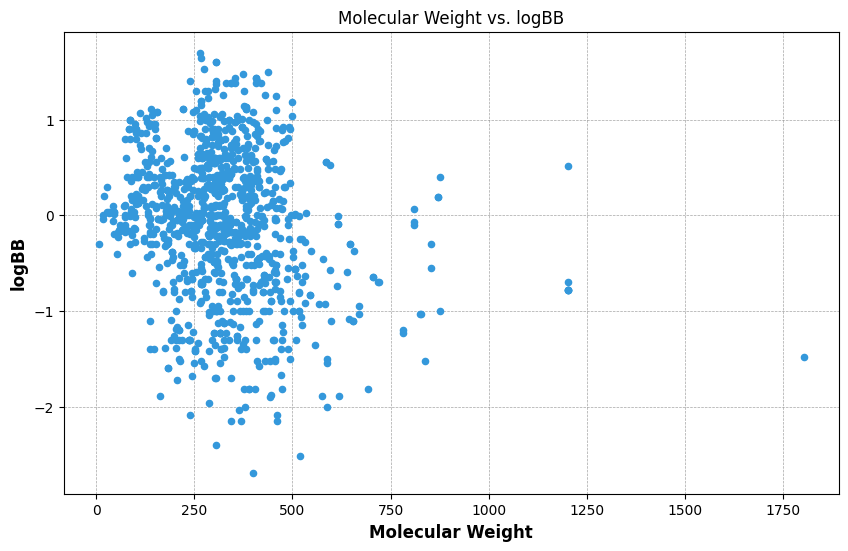

In [5]:
# create function to plot data
def make_scatter(data, x, y, xlabel, ylabel, title = None, color = '#3498db'):

    # create title
    if title is None:
        title = xlabel + ' vs. ' + ylabel

    # set figure dimensions
    plt.figure(figsize=(10, 6))

    # plot data points
    plt.scatter(data[x], data[y], s=20, color=color)

    # set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel, fontweight='bold', size=12)
    plt.ylabel(ylabel, fontweight='bold', size=12)

    # add a gray dashed grid in the background
    plt.grid(axis = "both", color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.gca().set_axisbelow(True)

    # return plot
    return plt

# plot molecular weight vs. logBB
plt = make_scatter(data, 'mol_wt', 'logBB', 'Molecular Weight', 'logBB')
plt.show()

Calculate uncertainties.

In [19]:
# compute fingerprints
data['fingerprints'] = data['mol'].apply(lambda x: Chem.AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))

# convert to numpy arrays
np_fingerprints = []
for fp in data['fingerprints']:
    array = np.zeros((0, ), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, array)
    np_fingerprints.append(array)

Perform hierarchical clustering.

In [29]:
# perform hierarchical clustering
num_clusters = 50  # You can adjust the number of clusters
clustering = AgglomerativeClustering(n_clusters = num_clusters, metric = 'euclidean', linkage = 'ward')
cluster_labels = clustering.fit_predict(np_fingerprints)

Assign cluster identity to each compound.

In [31]:
# assign cluster identity
data['cluster'] = cluster_labels

# within each cluster compute SEM of logBB
cluster_summary = data.groupby('cluster')['logBB'].agg(['mean', 'sem'])

# data[data['cluster'] == 40]['mol'][30]
# data[data['cluster'] == 40]['mol'][178]